In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20
       }
matplotlib.rc('font', **font)

In [3]:
from os import chdir

chdir("/home/jaimedgp/Repositories/AirQualityCOVID/")

In [4]:
data = pd.read_csv("data/results.csv")

data["date"] = pd.to_datetime(data["date"])

In [5]:
a = pd.pivot_table(data, 
                   columns=["Municipio"], 
                   index=["date"]
                  ).drop([("diff", "Marbella"),
                          #("diff", "Almería"),
                         ], axis=1)

In [6]:
a = (a - a.min()) / (a.max() - a.min())

In [7]:
def replace_nan(time_serie):
    #for i in index:
    time_serie.interpolate(limit_direction="both",inplace=True)
    
    return time_serie
    
a = a.apply(replace_nan).droplevel(None, axis=1)

In [8]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from sklearn.preprocessing import MinMaxScaler

/home/jaimedgp/.local/lib/python3.7/site-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "


In [9]:
q = to_time_series_dataset(a.T.to_numpy(
                  ).reshape(a.shape[1], a.shape[0], 1))

```python
from tslearn.barycenters import softdtw_barycenter, dtw_barycenter_averaging

means = pd.DataFrame(data={"mean":a.mean(axis=1).values, 
                           "softdtw":softdtw_barycenter(q).ravel(), 
                           "dtw":dtw_barycenter_averaging(q).ravel()})

means.plot()
```

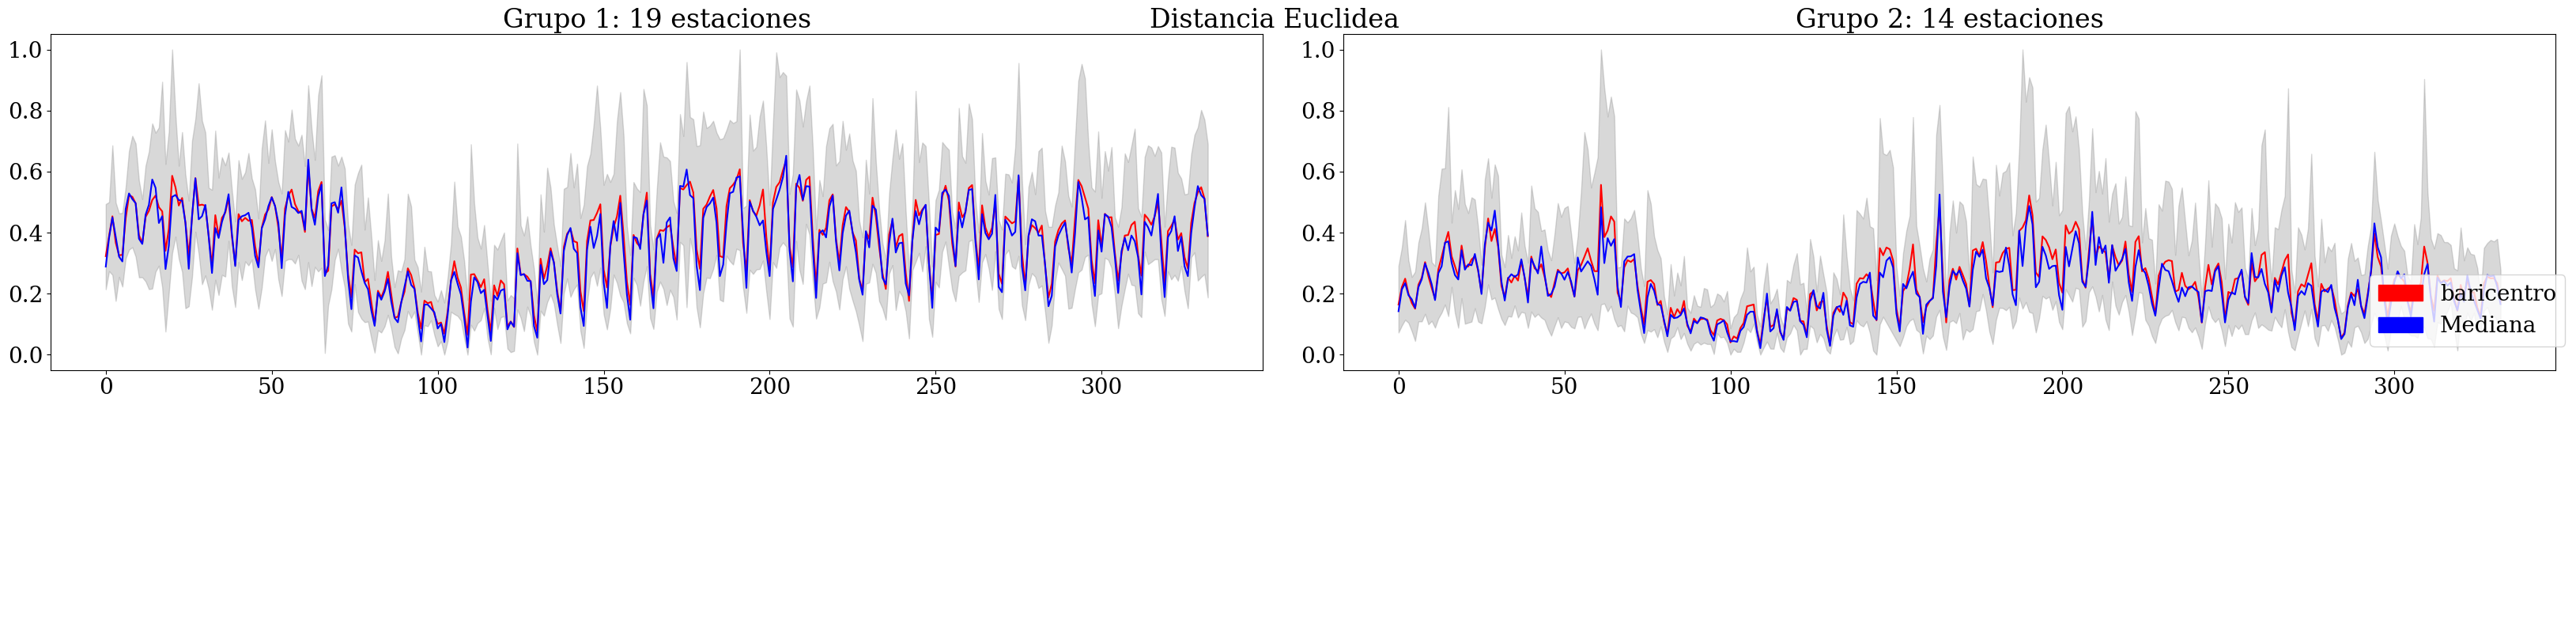

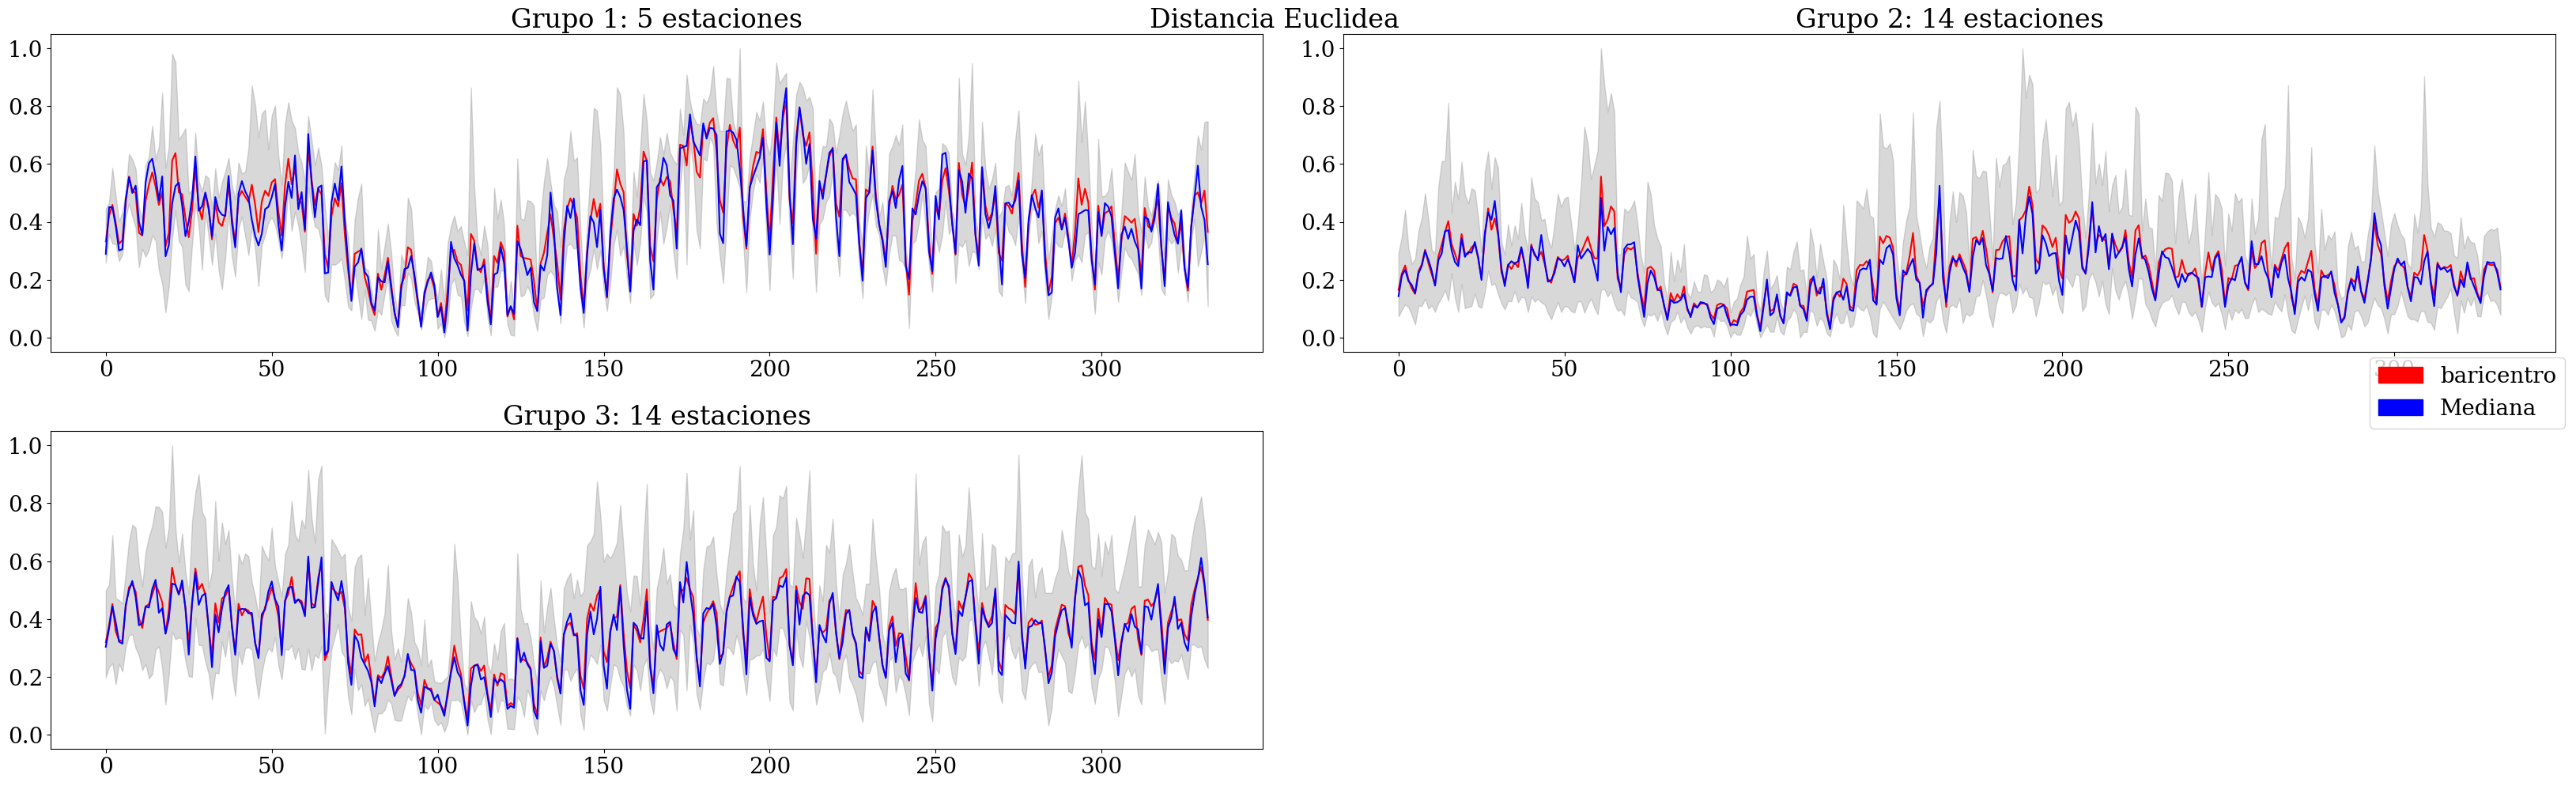

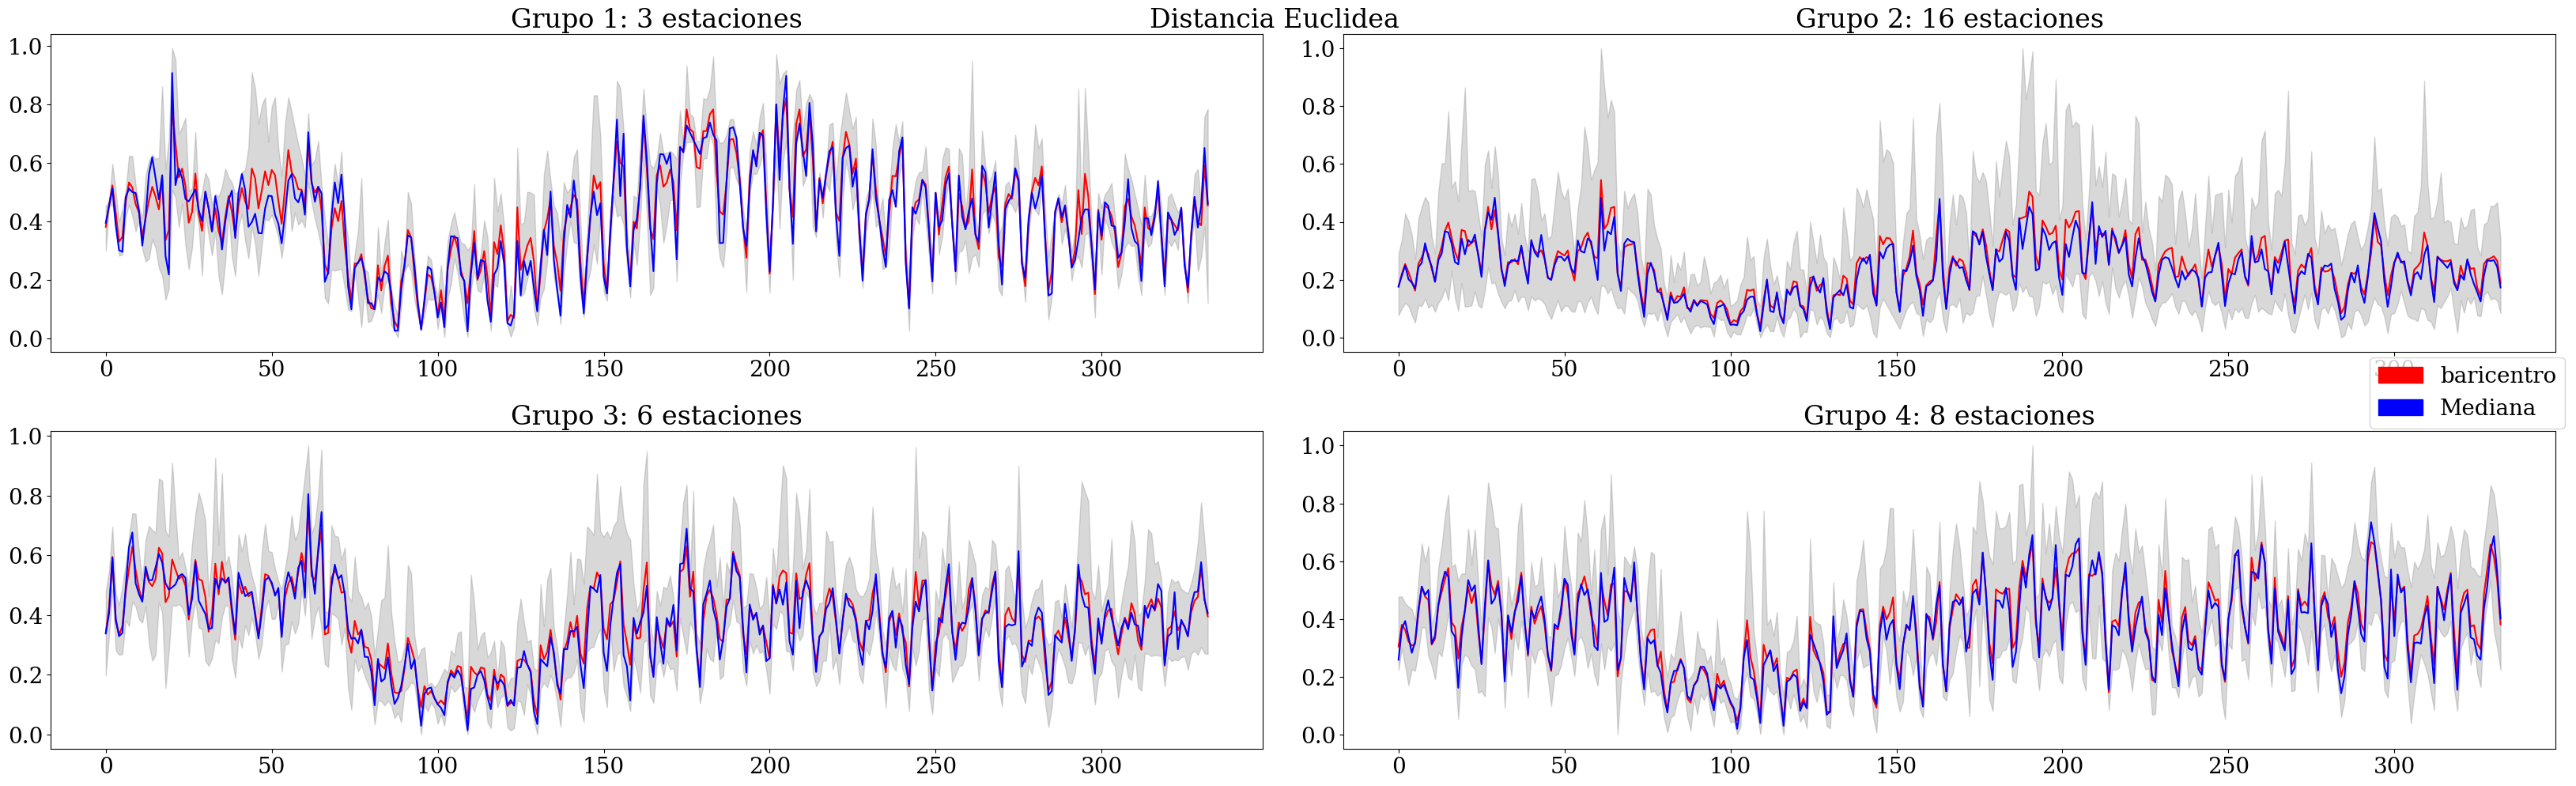

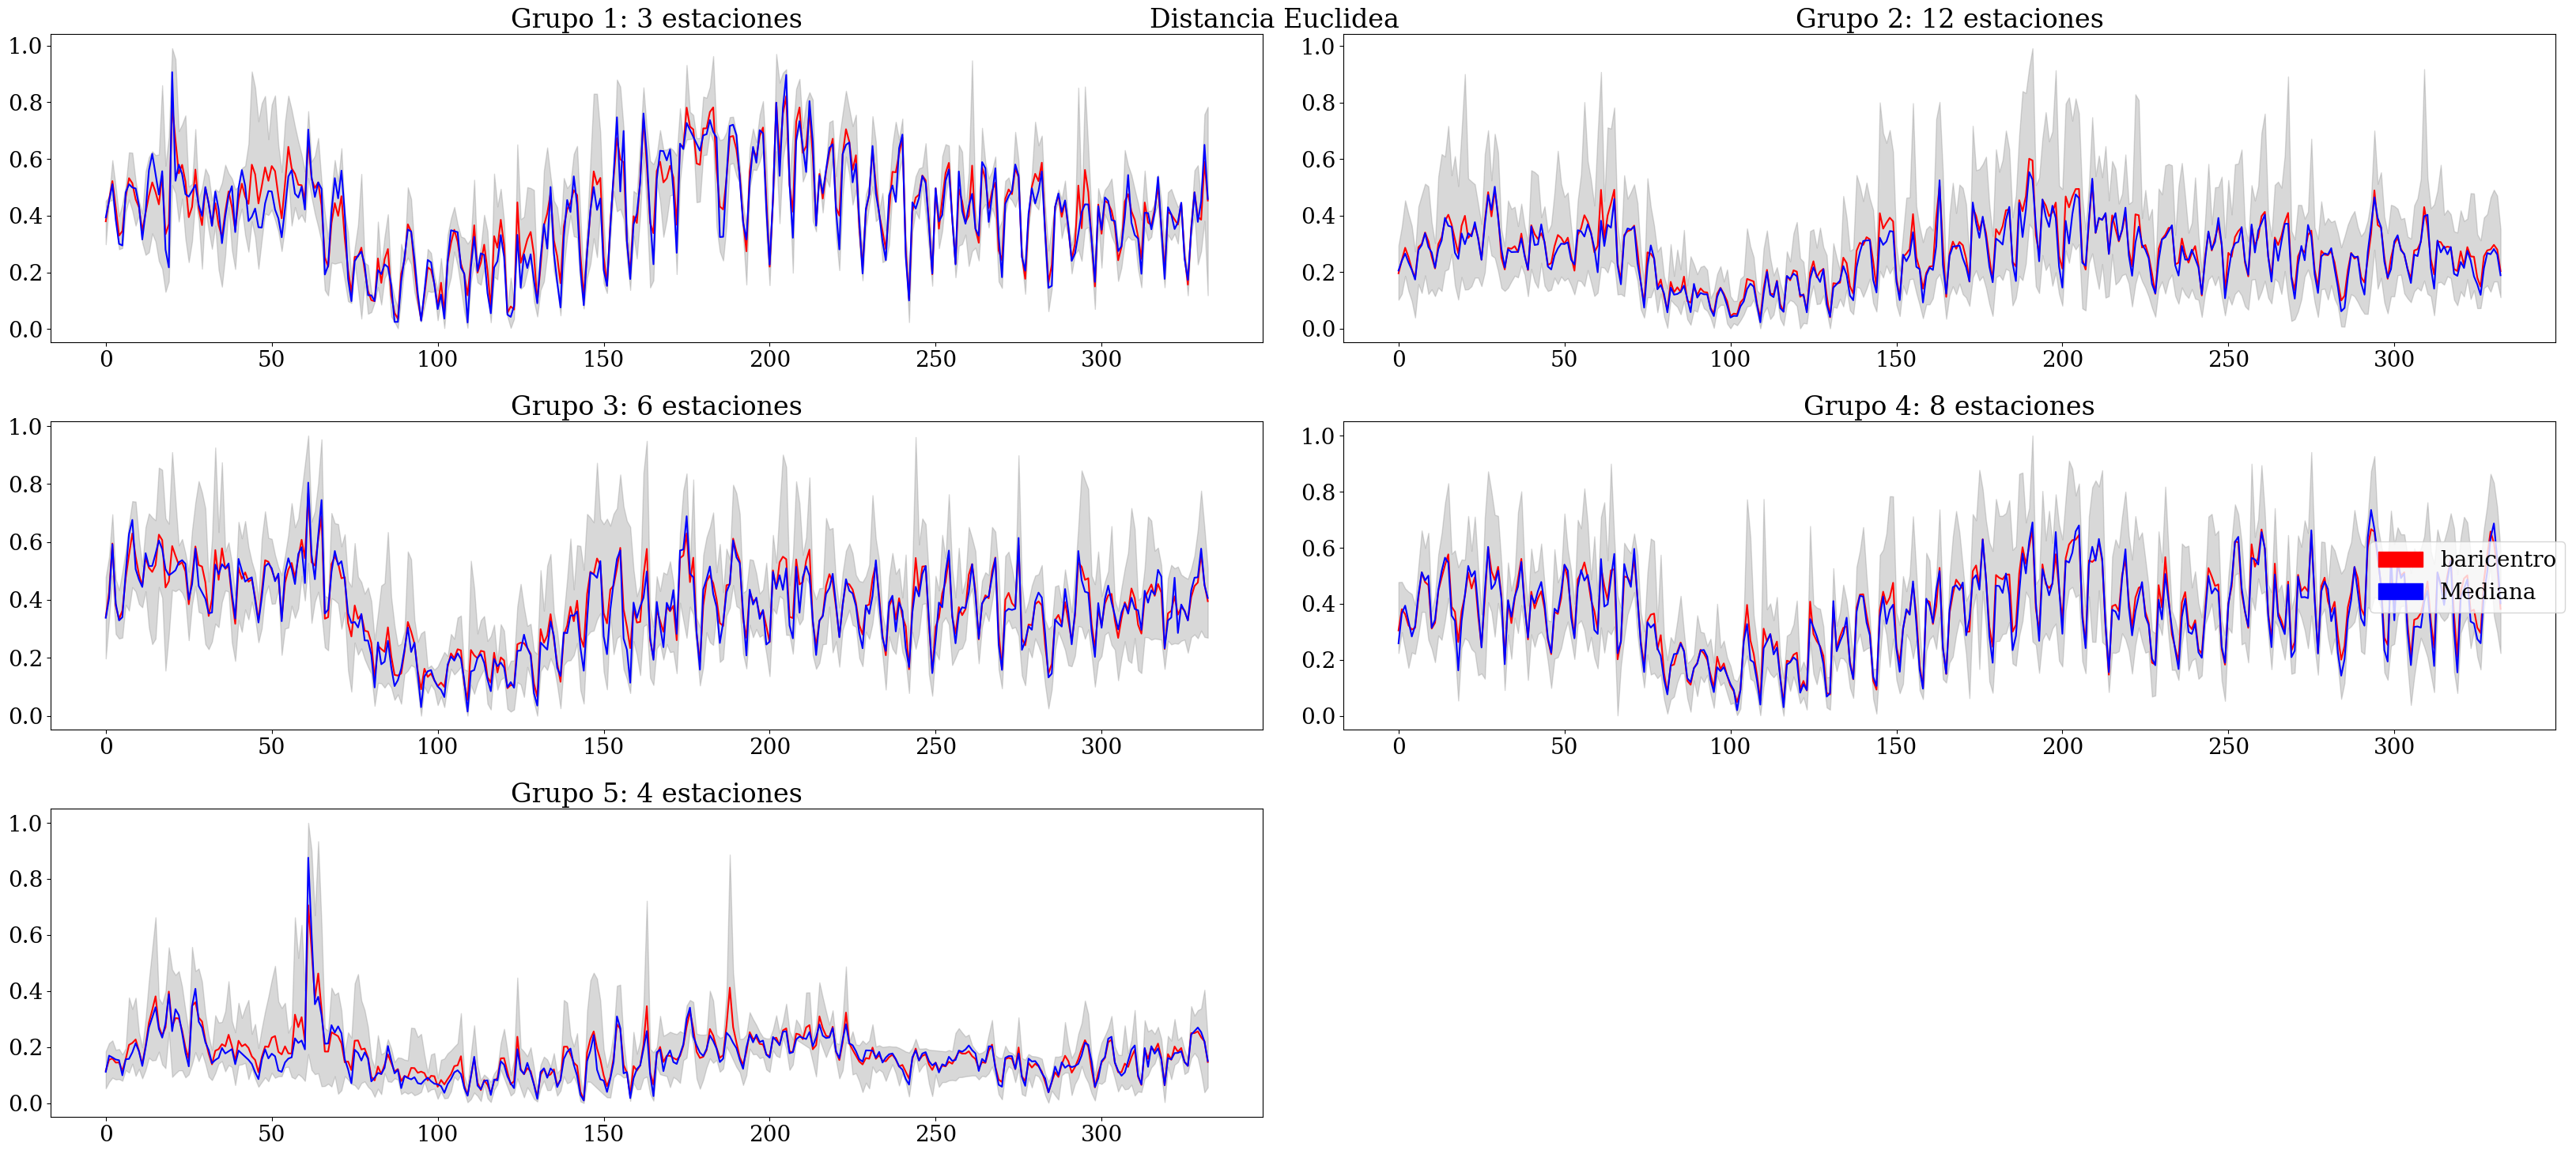

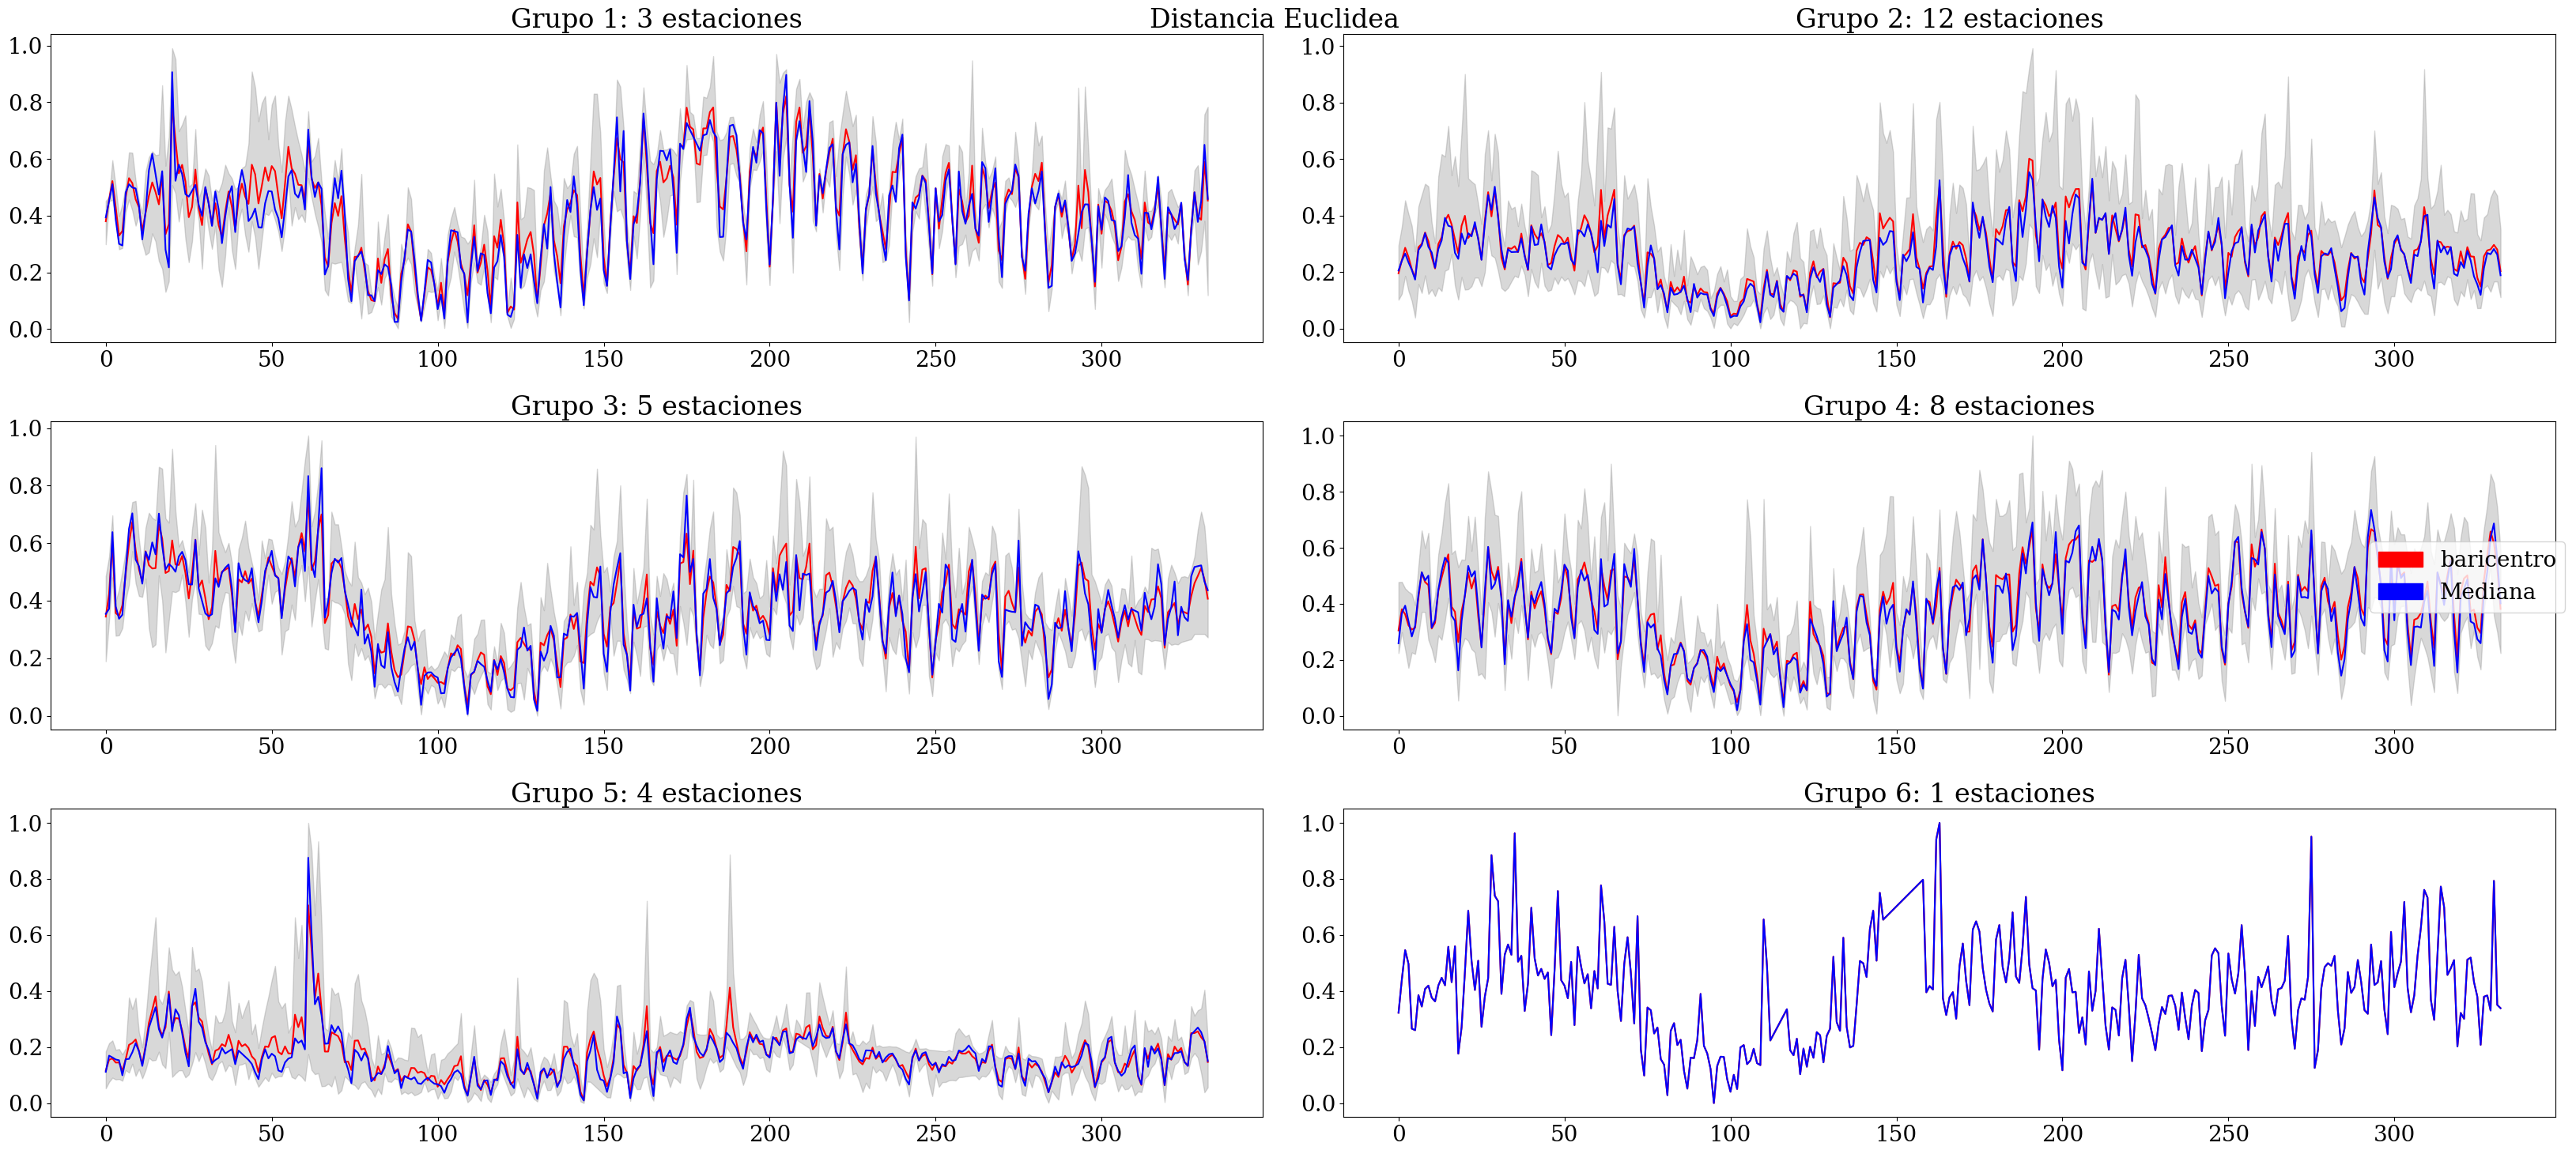

In [10]:
seed = 0
np.random.seed(seed)

for j in [2, 3, 4, 5, 6]:
    model = TimeSeriesKMeans(n_clusters=j, 
                             metric="euclidean",
                             verbose=False,
                             max_iter_barycenter=5,
                             #metric_params={"gamma": .01},
                             n_jobs = 6,
                             random_state=seed
                            )

    result = model.fit_predict(q)

    fig=plt.figure(figsize=(33,15), dpi= 100, facecolor='w', edgecolor='k')

    labels = "123456789dodtcqssonv"
    groups = pd.DataFrame()

    for i, s in enumerate(model.cluster_centers_):

        num_sites = len(a.columns[np.where(result == i)])
        groups = pd.concat([groups, 
                            pd.DataFrame({"group" : i, 
                                          "site": a.columns[np.where(result == i)]})])
        groups.to_csv("notebooks/Analysis/Clustering/Euclidea/groups"+str(j)+".csv", index=False)

        ax = plt.subplot(321+i)
        ax.plot(s.ravel(), color="r")

        cluster = q[np.where(result == i)]
        q_05 = np.quantile(cluster, 0.05, axis=0)
        q_95 = np.quantile(cluster, 0.95, axis=0)
        q_5 = np.quantile(cluster, 0.5, axis=0)

        ax.fill_between(np.arange(0, 333, 1), 
                        q_05.ravel(), q_95.ravel(), 
                        color="gray", alpha=0.3)

        ax.plot(q_5, color="blue")
        ax.set_title("Grupo "+str(i+1) + ": "+str(num_sites)+" estaciones")

    fig.suptitle("Distancia Euclidea")
    fig.legend(handles=[mpatches.Patch(color='r', label='baricentro'),
                mpatches.Patch(color='b', label='Mediana')], loc="center right")
    fig.tight_layout()
    fig.savefig("Plots/Euclidea/"+str(j)+"_clusters.png")
#plt.show()

